In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder

In [3]:
# Load the data
data = pd.read_csv('CIC_IoMT_2024_WiFi_MQTT_train.csv')
X = data.drop(columns=['label'])
y = data['label']

In [5]:
# Convert string labels in 'y' to numerical using LabelEncoder
label_encoder = LabelEncoder() # Create a LabelEncoder object
y = label_encoder.fit_transform(y) # Fit and transform the target variable

In [7]:
# Convert string features in 'X' to numerical using LabelEncoder or OneHotEncoder
for column in X.select_dtypes(include=['object']).columns:
    # Use LabelEncoder if the feature is ordinal (has a meaningful order)
    # or OneHotEncoder if the feature is nominal (no meaningful order)
    # Here, we are using LabelEncoder for demonstration purposes.
    # You might need to use OneHotEncoder depending on your data.
    X[column] = label_encoder.fit_transform(X[column])

In [9]:
# === Perform Stratified Downsampling ===
reduction_fraction = 0.1  # e.g., 10% of data

X, _, y, _ = train_test_split(
    X, y,
    train_size=reduction_fraction,
    stratify=y,
    random_state=42
)

# Confirm class ratios are preserved
print("Original class distribution:")
print(pd.Series(label_encoder.transform(data['label'])).value_counts(normalize=True).sort_index())

print("\nReduced class distribution:")
print(pd.Series(y).value_counts(normalize=True).sort_index())

Original class distribution:
0     0.002241
1     0.026915
2     0.024164
3     0.003858
4     0.001784
5     0.006197
6     0.000716
7     0.002351
8     0.000103
9     0.011728
10    0.000303
11    0.027223
12    0.027206
13    0.026493
14    0.026916
15    0.027236
16    0.026655
17    0.025978
18    0.027000
19    0.027845
20    0.028442
21    0.028212
22    0.027494
23    0.028252
24    0.027522
25    0.028499
26    0.028069
27    0.028791
28    0.028948
29    0.028852
30    0.028816
31    0.028699
32    0.028244
33    0.027606
34    0.028503
35    0.014594
36    0.013543
37    0.015178
38    0.014820
39    0.015561
40    0.015591
41    0.015109
42    0.015450
43    0.013323
44    0.013339
45    0.013402
46    0.013055
47    0.019133
48    0.019620
49    0.020409
50    0.020012
Name: proportion, dtype: float64

Reduced class distribution:
0     0.002241
1     0.026914
2     0.024165
3     0.003857
4     0.001783
5     0.006198
6     0.000716
7     0.002350
8     0.000103
9     0.0

In [11]:
# Train the Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

RandomForestClassifier(random_state=42)

In [13]:
import numpy as np
import pandas as pd

# Initialize scores
n_features = X.shape[1]
feature_scores = np.zeros(n_features)

for tree in rf.estimators_:
    tree_ = tree.tree_

    for node in range(tree_.node_count):
        feature = tree_.feature[node]

        # Skip leaf nodes
        if feature == -2:
            continue

        left = tree_.children_left[node]
        right = tree_.children_right[node]

        n_node_samples = tree_.n_node_samples[node]
        impurity_before = tree_.impurity[node]
        impurity_left = tree_.impurity[left]
        impurity_right = tree_.impurity[right]
        n_left = tree_.n_node_samples[left]
        n_right = tree_.n_node_samples[right]

        # Weighted impurity after split
        impurity_after = (n_left * impurity_left + n_right * impurity_right) / n_node_samples

        # Importance contribution
        importance_score = (impurity_before - impurity_after) * n_node_samples

        # Accumulate for the feature
        feature_scores[feature] += importance_score

In [15]:
# Normalize scores
feature_scores = feature_scores / feature_scores.sum()

# Final result as a pandas Series
final_scores = pd.Series(feature_scores, index=X.columns).sort_values(ascending=False)

In [17]:
# Plot before filtering (all features)
num_features = len(final_scores)
width_per_feature = 0.2
fig_width = max(15, num_features * width_per_feature)

Plot saved to IoMT_before_selection.png


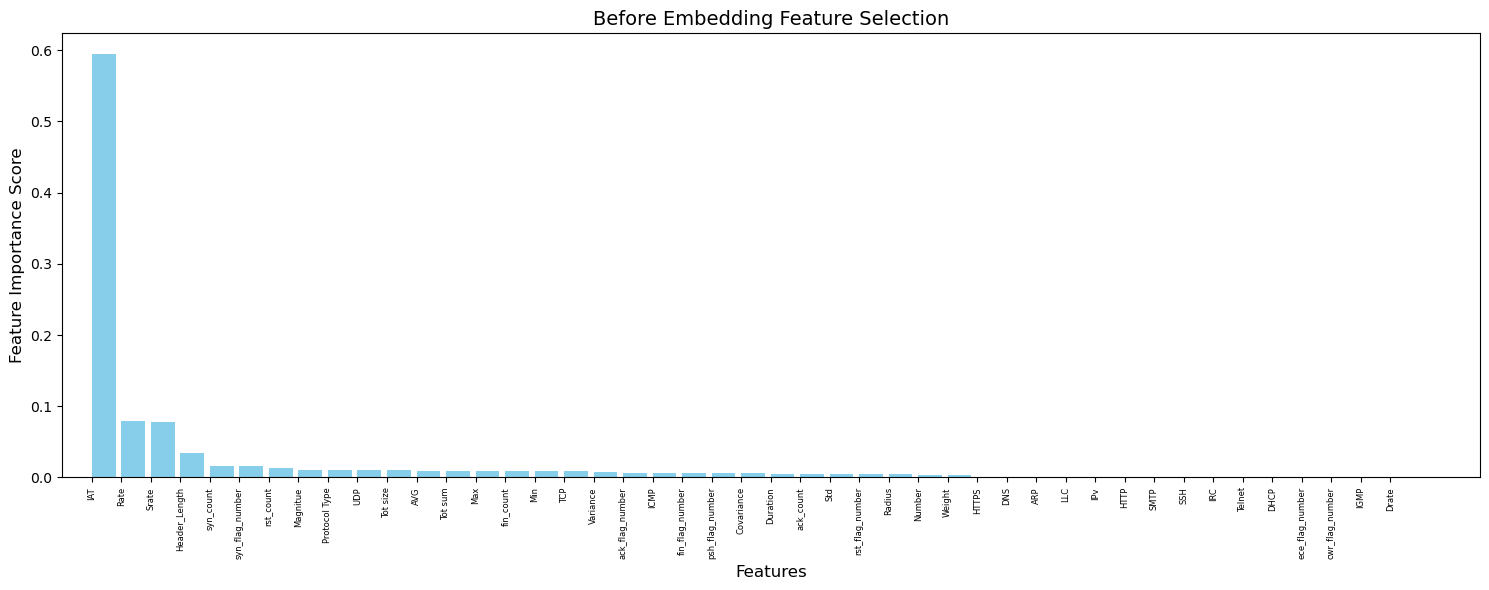

In [19]:
 plt.figure(figsize=(fig_width, 6))
plt.bar(final_scores.index, final_scores.values, color='skyblue', align='edge')
plt.xticks(rotation=90, fontsize=6)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Feature Importance Score", fontsize=12)
plt.title("Before Embedding Feature Selection", fontsize=14)
plt.xlim(left=-1)
plt.tight_layout()
# Specify the file path to save the plot
plot_path = "IoMT_before_selection.png"
plt.savefig(plot_path)  # Save the plot to a PNG file
print(f"Plot saved to {plot_path}")

plt.show()

In [21]:
# === Filter unimportant features ===
contributing_features = final_scores[final_scores > 0.0]
unimportant_features = final_scores[final_scores <= 0.0]

In [23]:
print(f"Original feature count: {len(final_scores)}")
print(f"Filtered feature count: {len(contributing_features)}")
print(f"Number of unimportant features: {len(unimportant_features)}")

Original feature count: 45
Filtered feature count: 44
Number of unimportant features: 1


In [25]:
 unimportant_features

Drate    0.0
dtype: float64

Plot saved to IoMT_after_selection.png


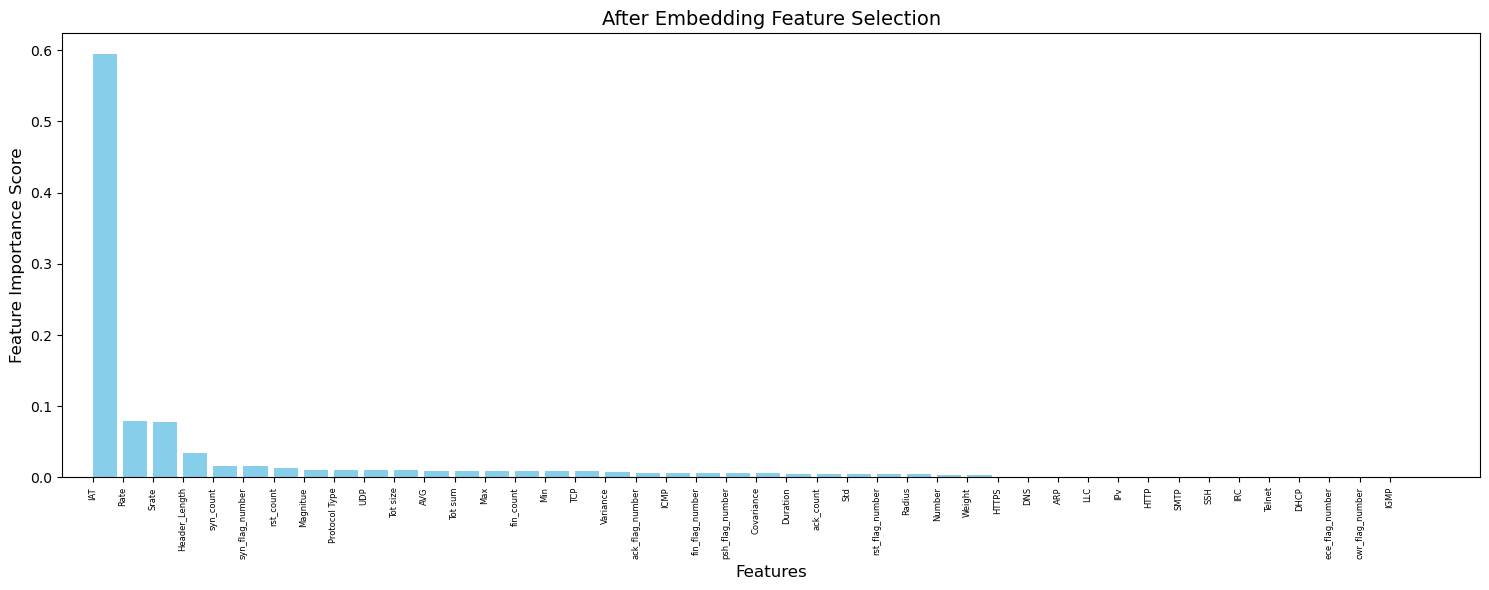

In [27]:
 num_features = len(contributing_features)
width_per_feature = 0.2
fig_width = max(15, num_features * width_per_feature)
plt.figure(figsize=(fig_width, 6))
plt.bar(contributing_features.index, contributing_features.values, color='skyblue', align='edge')
plt.xticks(rotation=90, fontsize=6)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Feature Importance Score", fontsize=12)
plt.title("After Embedding Feature Selection", fontsize=14)
plt.xlim(left=-1)
plt.tight_layout()
# Specify the file path to save the plot
plot_path_a = "IoMT_after_selection.png"
plt.savefig(plot_path_a)  # Save the plot to a PNG file
print(f"Plot saved to {plot_path_a}")
plt.show()

In [29]:
# Select only the important features from the reduced dataset
X_selected = X[contributing_features.index]

# Decode the reduced label array
decoded_labels = label_encoder.inverse_transform(y)

# Add decoded labels to the reduced, selected features
X_selected['label'] = decoded_labels

# Save the final dataset with decoded labels
X_selected.to_csv("IoMTFeatures.csv", index=False)

print("Saved 'IoMTFeatures.csv' with string labels.")


Saved 'IoMTFeatures.csv' with string labels.
